### **Pix2Pix**

**Importing Libraries**

In [1]:
import torch
import torch.nn as nn
from torch.utils.data import DataLoader
from torchvision import transforms
from torchvision.datasets import ImageFolder
import torch.nn.functional as F
from torchsummary import summary
from google.colab import drive
import numpy as np
import matplotlib.pyplot as plt
import plotly.graph_objects as go
from tqdm import tqdm
from IPython import display
import os
import pandas as pd

**Model Blocks**

In [ ]:
class ContractingBlock(nn.Module):
  def __init__(self, channels, use_bn=True, use_dropout=False):
    super().__init__()

    self.conv1 = nn.Conv2d(channels, channels*2, kernel_size=3, padding=1)
    self.conv2 = nn.Conv2d(channels*2, channels*2, kernel_size=3, padding=1)
    self.activation = nn.LeakyReLU(0.2)
    self.maxpool = nn.MaxPool2d(kernel_size=2, stride=2)

    if use_bn:
      self.batchnorm = nn.BatchNorm2d(channels*2)
    self.use_bn = use_bn

    if use_dropout:
      self.dropout = nn.Dropout()
    self.use_dropout = use_dropout

  def forward(self, x):
    x = self.conv1(x)
    if self.use_bn:
      x = self.batchnorm(x)
    if self.use_dropout:
      x = self.dropout(x)
    x = self.activation(x)
    x = self.conv2(x)
    if self.use_bn:
      x = self.batchnorm(x)
    if self.use_dropout:
      x = self.dropout(x)
    x = self.activation(x)
    x = self.maxpool(x)

    return x


def crop(image, new_shape):
  _, _, height, width = image.shape
  start_h = (height - new_shape[2]) // 2
  start_w = (width - new_shape[3]) // 2
  cropped_image = image[:, :, start_h : start_h+new_shape[2], start_w : start_w+new_shape[3]]
  return cropped_image


class ExpandingBlock(nn.Module):
  def __init__(self, channels, use_bn=True, use_dropout=False):
    super().__init__()

    self.upsample = nn.Upsample(scale_factor=2, mode="bilinear", align_corners=True)
    self.conv1 = nn.Conv2d(channels, channels//2, kernel_size=2)
    self.conv2 = nn.Conv2d(channels, channels//2, kernel_size=3, padding=1)
    self.conv3 = nn.Conv2d(channels//2, channels//2, kernel_size=2, padding=1)
    self.activation = nn.ReLU()

    if use_bn:
      self.batchnorm = nn.BatchNorm2d(channels//2)
    self.use_bn = use_bn

    if use_dropout:
      self.dropout = nn.Dropout()
    self.use_dropout = use_dropout

  def forward(self, x, skip_cont_x):
    x = self.upsample(x)
    x = self.conv1(x)
    skip_cont_x = crop(skip_cont_x, x.shape)
    x = torch.cat([x, skip_cont_x], axis=1)
    x = self.conv2(x)
    if self.use_bn:
      x = self.batchnorm(x)
    if self.use_dropout:
      x = self.dropout(x)
    x = self.activation(x)
    x = self.conv3(x)
    if self.use_bn:
      x = self.batchnorm(x)
    if self.use_dropout:
      x = self.dropout(x)
    x = self.activation(x)

    return x


class FeatureMapBlock(nn.Module):
  def __init__(self, input_channels, output_channels):
    super().__init__()
    self.conv = nn.Conv2d(input_channels, output_channels, kernel_size=1)

  def forward(self, x):
    x = self.conv(x)
    return x

In [ ]:
# Parameters

epochs = 20
img_channels =3
mask_channels = 3
images_size = 256
batch_size = 16
lr = 0.0002
device = "cuda"

**Models**

In [ ]:
class UNet(nn.Module):
  def __init__(self, input_channels, output_channels, hidden_channels=32):
    super().__init__()

    self.upfeature = FeatureMapBlock(input_channels, hidden_channels)
    self.contract1 = ContractingBlock(hidden_channels, use_dropout=True)
    self.contract2 = ContractingBlock(hidden_channels*2, use_dropout=True)
    self.contract3 = ContractingBlock(hidden_channels*4, use_dropout=True)
    self.contract4 = ContractingBlock(hidden_channels*8)
    self.contract5 = ContractingBlock(hidden_channels*16)
    self.contract6 = ContractingBlock(hidden_channels*32)
    self.expand0 = ExpandingBlock(hidden_channels*64)
    self.expand1 = ExpandingBlock(hidden_channels*32)
    self.expand2 = ExpandingBlock(hidden_channels*16)
    self.expand3 = ExpandingBlock(hidden_channels*8)
    self.expand4 = ExpandingBlock(hidden_channels*4)
    self.expand5 = ExpandingBlock(hidden_channels*2)
    self.downfeature = FeatureMapBlock(hidden_channels, output_channels)
    self.sigmoid = nn.Sigmoid()

  def forward(self, x):

    x0 = self.upfeature(x)
    x1 = self.contract1(x0)
    x2 = self.contract2(x1)
    x3 = self.contract3(x2)
    x4 = self.contract4(x3)
    x5 = self.contract5(x4)
    x6 = self.contract6(x5)
    x7 = self.expand0(x6, x5)
    x8 = self.expand1(x7, x4)
    x9 = self.expand2(x8, x3)
    x10 = self.expand3(x9, x2)
    x11 = self.expand4(x10, x1)
    x12 = self.expand5(x11, x0)
    xn = self.downfeature(x12)
    xn = self.sigmoid(xn)

    return xn

In [ ]:
generator = UNet(img_channels, mask_channels).to(device)

summary(generator, (img_channels, images_size, images_size))

----------------------------------------------------------------
        Layer (type)               Output Shape         Param #
            Conv2d-1         [-1, 32, 256, 256]             128
   FeatureMapBlock-2         [-1, 32, 256, 256]               0
            Conv2d-3         [-1, 64, 256, 256]          18,496
       BatchNorm2d-4         [-1, 64, 256, 256]             128
           Dropout-5         [-1, 64, 256, 256]               0
         LeakyReLU-6         [-1, 64, 256, 256]               0
            Conv2d-7         [-1, 64, 256, 256]          36,928
       BatchNorm2d-8         [-1, 64, 256, 256]             128
           Dropout-9         [-1, 64, 256, 256]               0
        LeakyReLU-10         [-1, 64, 256, 256]               0
        MaxPool2d-11         [-1, 64, 128, 128]               0
 ContractingBlock-12         [-1, 64, 128, 128]               0
           Conv2d-13        [-1, 128, 128, 128]          73,856
      BatchNorm2d-14        [-1, 128, 1

In [ ]:
class Discriminator(nn.Module):
  def __init__(self, channels, hidden_channels=8):
    super(Discriminator, self).__init__()

    self.upfeature = FeatureMapBlock(channels, hidden_channels)
    self.contract1 = ContractingBlock(hidden_channels, use_bn=False)
    self.contract2 = ContractingBlock(hidden_channels*2)
    self.contract3 = ContractingBlock(hidden_channels*4)
    self.contract4 = ContractingBlock(hidden_channels*8)
    self.final = nn.Conv2d(hidden_channels*16, 1, kernel_size=1)

  def forward(self, x, y):
    x = torch.cat([x, y], axis=1)
    x0 = self.upfeature(x)
    x1 = self.contract1(x0)
    x2 = self.contract2(x1)
    x3 = self.contract3(x2)
    x4 = self.contract4(x3)
    xn = self.final(x4)
    return xn

In [ ]:
discriminator = Discriminator(img_channels + mask_channels).to(device)

summary(discriminator, [(mask_channels, images_size, images_size), (img_channels, images_size, images_size)])

----------------------------------------------------------------
        Layer (type)               Output Shape         Param #
            Conv2d-1          [-1, 8, 256, 256]              56
   FeatureMapBlock-2          [-1, 8, 256, 256]               0
            Conv2d-3         [-1, 16, 256, 256]           1,168
         LeakyReLU-4         [-1, 16, 256, 256]               0
            Conv2d-5         [-1, 16, 256, 256]           2,320
         LeakyReLU-6         [-1, 16, 256, 256]               0
         MaxPool2d-7         [-1, 16, 128, 128]               0
  ContractingBlock-8         [-1, 16, 128, 128]               0
            Conv2d-9         [-1, 32, 128, 128]           4,640
      BatchNorm2d-10         [-1, 32, 128, 128]              64
        LeakyReLU-11         [-1, 32, 128, 128]               0
           Conv2d-12         [-1, 32, 128, 128]           9,248
      BatchNorm2d-13         [-1, 32, 128, 128]              64
        LeakyReLU-14         [-1, 32, 1

**[Dataset](https://drive.google.com/drive/folders/19giwoxuUnRg0-5cB9SJS7ETY9fmuBOgd?usp=drive_link)**

In [ ]:
drive.mount("/content/drive/")

Mounted at /content/drive/


In [ ]:
def preprocess_data(images):
  image_width = images.shape[3]
  imgs = images[:, :, :, :image_width // 2]
  imgs = F.interpolate(imgs, size=images_size)
  masks = images[:, :, :, image_width // 2:]
  masks = F.interpolate(masks, size=images_size)
  return imgs, masks

In [ ]:
transform = transforms.Compose([
    transforms.ToTensor(),
])

dataset = ImageFolder("/content/drive/MyDrive/maps", transform=transform)
train_dataset = DataLoader(dataset, batch_size=batch_size, shuffle=True)

In [ ]:
len(dataset)

2198

In [ ]:
for images, _ in train_dataset: # All labels are 0
  imgs, masks = preprocess_data(images)
  print(imgs.shape, masks.shape)
  break

torch.Size([16, 3, 256, 256]) torch.Size([16, 3, 256, 256])


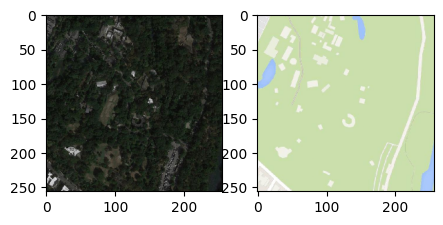

In [ ]:
fig, ax = plt.subplots(1, 2, figsize=(5, 5))
ax[0].imshow(imgs[0].permute(1, 2, 0))
ax[1].imshow(masks[0].permute(1, 2, 0))
plt.show()

In [ ]:
# Images are already normalized between [0; 1]

imgs.min(), imgs.max(), masks.min(), masks.max()

(tensor(0.), tensor(1.), tensor(0.), tensor(1.))

**Pix2Pix Training**

In [ ]:
gen_optimizer = torch.optim.Adam(generator.parameters(), lr=lr)
disc_optimizer = torch.optim.Adam(discriminator.parameters(), lr=lr)

adversarial_criterion = nn.BCEWithLogitsLoss()
reconstruct_criterion = nn.L1Loss()
lambda_reconstruct = 200

In [ ]:
def weights_init(m):
  if isinstance(m, nn.Conv2d) or isinstance(m, nn.ConvTranspose2d):
    nn.init.normal_(m.weight, 0.0, 0.02)
  if isinstance(m, nn.BatchNorm2d):
    nn.init.normal_(m.weight, 0.0, 0.02)
    nn.init.constant_(m.bias, 0)

Checkpointing is crucial for lengthy training processes; 'load_state_dict' ensures continuity of progress in PyTorch.

In [ ]:
pretrained = True #Change according to previous training
checkpoint_folder = "/content/drive/MyDrive/checkpoints/Pytorch_Pix2Pix/"

if pretrained:
  last_epoch = 30 #Put the last epoch of the pretrained model

  loaded_state = torch.load(os.path.join(checkpoint_folder, f"epoch_{last_epoch}.pth"))
  generator.load_state_dict(loaded_state["generator"])
  gen_optimizer.load_state_dict(loaded_state["gen_optimizer"])
  discriminator.load_state_dict(loaded_state["discriminator"])
  disc_optimizer.load_state_dict(loaded_state["disc_optimizer"])

  history = pd.read_csv(os.path.join(checkpoint_folder, f"losses_epoch_{last_epoch}.csv"))
  history = history.to_dict(orient="list")

else:
  last_epoch = 0

  os.makedirs(checkpoint_folder, exist_ok=True)
  generator = generator.apply(weights_init)
  discriminator = discriminator.apply(weights_init)

  history = {"gen_loss":[], "disc_loss":[]}

In [ ]:
def show_images(real_images, labels, labels_pred, num_examples, cmap=None):

  real_images = real_images.cpu()
  labels = labels.cpu()
  labels_pred = labels_pred.cpu()

  fig, ax = plt.subplots(num_examples, 3, figsize=(3*num_examples, 2.5*num_examples))
  for i in range(num_examples):
    ax[i, 0].imshow(real_images[i].permute(1, 2, 0), cmap=cmap)
    ax[i, 0].axis("off")
    ax[i, 1].imshow(labels[i].permute(1, 2, 0), cmap=cmap)
    ax[i, 1].axis("off")
    ax[i, 2].imshow(labels_pred[i].permute(1, 2, 0), cmap=cmap)
    ax[i, 2].axis("off")

  ax[0, 0].set_title("Image", fontsize=10)
  ax[0, 1].set_title("Mask", fontsize=10)
  ax[0, 2].set_title("Predicted Mask", fontsize=10)
  plt.show()

In [ ]:
def train_model(epochs=epochs, history=history, num_examples=2, save_model=True, display_wait=False):

  for epoch in range(epochs):
    gen_loss_list, disc_loss_list = [], []
    current_epoch = last_epoch + epoch +1

    with tqdm(train_dataset) as pbar:
      pbar.set_description(f"[Epoch: {current_epoch}/{last_epoch + epochs}]")
      for images, _ in pbar:
        imgs, masks = preprocess_data(images)
        imgs = imgs.to(device)
        masks = masks.to(device)

        # Update discriminator
        disc_optimizer.zero_grad()
        with torch.no_grad():
          fake_masks = generator(imgs)

        fake_out = discriminator(fake_masks.detach(), imgs)
        fake_loss = adversarial_criterion(fake_out, torch.zeros_like(fake_out))
        real_out = discriminator(masks, imgs)
        real_loss = adversarial_criterion(real_out, torch.ones_like(real_out))
        disc_loss = (fake_loss+real_loss) / 2

        disc_loss.backward(retain_graph=True)
        disc_optimizer.step()

        # Update generator
        gen_optimizer.zero_grad()

        fake_masks = generator(imgs)
        fake_out = discriminator(fake_masks, imgs)
        fake_loss_adv = adversarial_criterion(fake_out, torch.ones_like(fake_out))
        fake_loss_recon = reconstruct_criterion(fake_masks, masks)
        gen_loss = fake_loss_adv + lambda_reconstruct*fake_loss_recon

        gen_loss.backward()
        gen_optimizer.step()

        gen_loss_list.append(gen_loss.item())
        disc_loss_list.append(disc_loss.item())
        pbar.set_postfix({"gen_loss":gen_loss.item(), "disc_loss":disc_loss.item()})

    gen_loss_mean = np.mean(gen_loss_list)
    disc_loss_mean = np.mean(disc_loss_list)
    history["gen_loss"].append(gen_loss_mean)
    history["disc_loss"].append(disc_loss_mean)

    display.clear_output(wait=display_wait)
    print(f"Epoch {current_epoch}, Generator (U-Net) Loss: {gen_loss_mean}, Discriminator Loss: {disc_loss_mean}")
    show_images(imgs, masks, fake_masks.detach(), num_examples=num_examples)

    if save_model and (current_epoch % 10 == 0):
      torch.save({"generator": generator.state_dict(),
                  "gen_optimizer": gen_optimizer.state_dict(),
                  "discriminator": discriminator.state_dict(),
                  "disc_optimizer": disc_optimizer.state_dict()},
                 os.path.join(checkpoint_folder, f"epoch_{current_epoch}.pth"))

      df = pd.DataFrame(history)
      df.to_csv(os.path.join(checkpoint_folder, f"losses_epoch_{current_epoch}.csv"), index=False)

  return history

Epoch 50, Generator (U-Net) Loss: 9.945757596389107, Discriminator Loss: 0.3801441478232543


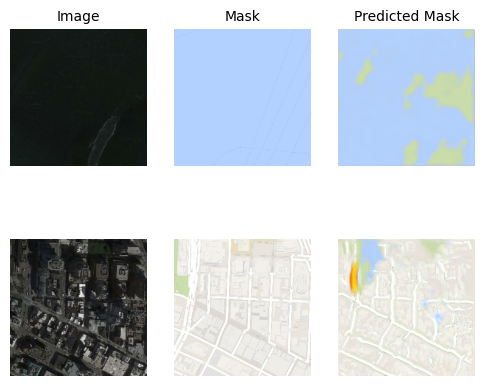

In [ ]:
history = train_model()

In [14]:
def plot_metrics(history, renderer=None, epochs = last_epoch + epochs + 1):
  gen_losses=history["gen_loss"]
  disc_losses=history["disc_loss"]
  list_epochs=np.arange(1, epochs+1)

  fig=go.Figure()
  fig.add_trace(go.Scatter(x=list_epochs, y=gen_losses, name="Generator Loss", line=dict(color="blue", width=2)))
  fig.add_trace(go.Scatter(x=list_epochs, y=disc_losses, name="Discriminator Loss", line=dict(color="#FF6600", width=2)))
  fig.update_xaxes(title_text="Epoch")
  fig.update_yaxes(title_text="Loss")
  fig.update_layout(title=f"<b>Evolution of Loss across Epochs</b>",
                    title_font=dict(size=20),
                    title_x=0.5,
                    height=500,
                    width=1200)

  fig.show(renderer)

In [15]:
# Interactive graphic
plot_metrics(history)

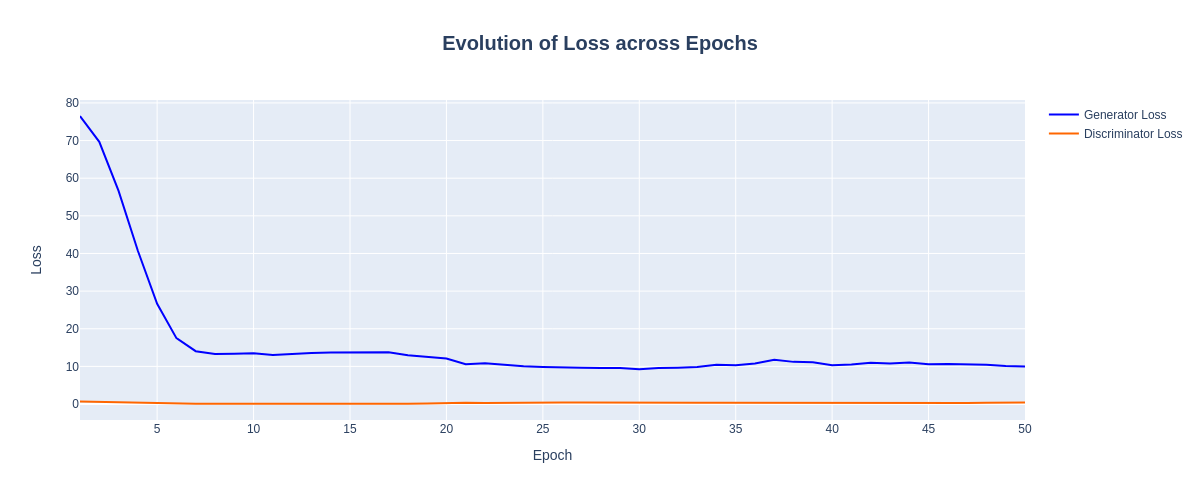

In [17]:
# Image for GitHub
plot_metrics(history, renderer="png")

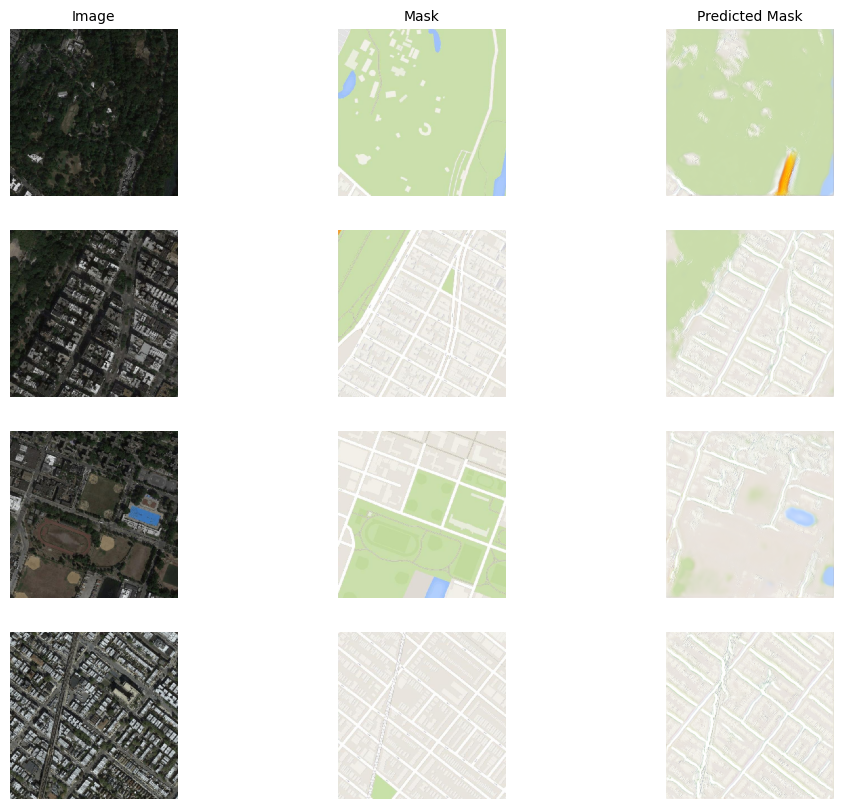

In [ ]:
# Examples
masks_pred = generator(imgs.to(device)).detach()
show_images(imgs, masks, masks_pred, num_examples=4)